In [2]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

from models.dino import utils
from models.dino import vision_transformer as vits

In [3]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

In [4]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [5]:
def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [105]:
arch = 'vit_small'
patch_size = 8
pretrained_weights = './checkpoints/dino/B14_vit_s_8_all/checkpoint.pth'
checkpoint_key = 'teacher'
threshold = None

data_path = '/p/scratch/hai_dm4eo/wang_yi/BigEarthNet_LMDB'
image_path = '.'

In [106]:
model = vits.__dict__[arch](patch_size=8, num_classes=0, in_chans = 14)
for p in model.parameters():
    p.requires_grad = False
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(14, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv

In [107]:
state_dict = torch.load(pretrained_weights, map_location="cpu")
state_dict = state_dict[checkpoint_key]
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)
print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

Pretrained weights found at ./checkpoints/dino/B14_vit_s_8_all/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [108]:
from datasets.BigEarthNet.bigearthnet_dataset_seco_lmdb_B14 import LMDBDataset
from cvtorchvision import cvtransforms

train_dataset = LMDBDataset(
        lmdb_file='/p/scratch/hai_dm4eo/wang_yi/BigEarthNet_LMDB/train_B12_B2.lmdb',
        transform=cvtransforms.Compose([cvtransforms.ToTensor()])
        #transform=transform
    )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=0)

['Arable land']


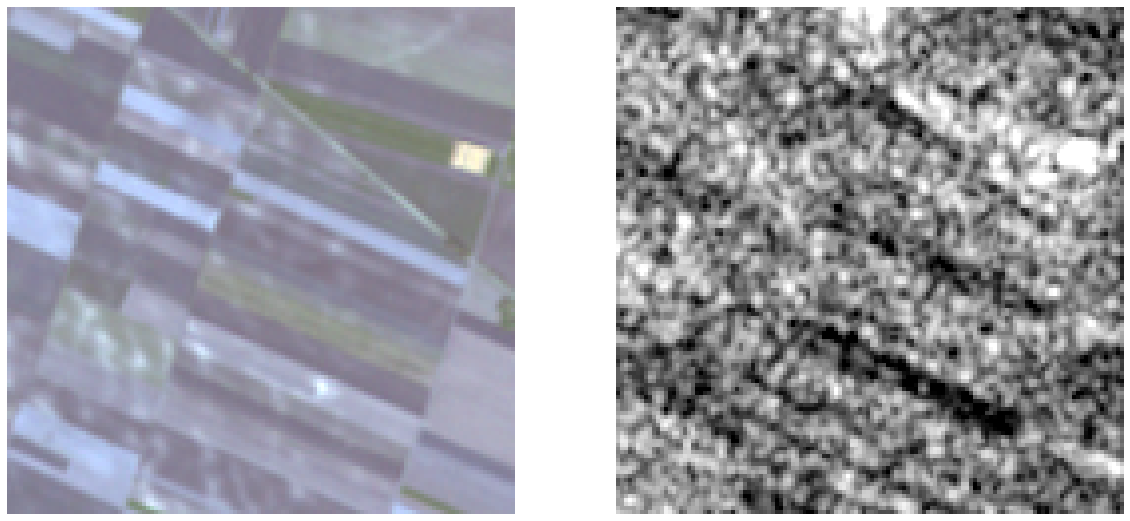

In [117]:
NEW_LABELS = [
    'Urban fabric',
    'Industrial or commercial units',
    'Arable land',
    'Permanent crops',
    'Pastures',
    'Complex cultivation patterns',
    'Land principally occupied by agriculture, with significant areas of natural vegetation',
    'Agro-forestry areas',
    'Broad-leaved forest',
    'Coniferous forest',
    'Mixed forest',
    'Natural grassland and sparsely vegetated areas',
    'Moors, heathland and sclerophyllous vegetation',
    'Transitional woodland/shrub',
    'Beaches, dunes, sands',
    'Inland wetlands',
    'Coastal wetlands',
    'Inland waters',
    'Marine waters'
]
plt.figure(figsize=(20,20))
for idx, (imgs,target) in enumerate(train_loader):
    if idx>45:
        break
img = imgs[0]
img1 = imgs[0].permute(1, 2, 0)
plt.subplot(1,2,1)
plt.imshow(img1[:,:,1:4])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1[:,:,13],cmap='gray')
plt.axis('off')

#print(target)
target_name = [NEW_LABELS[idd] for idd in range(19) if target[0,idd]]
print(target_name)
        


In [118]:
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

print(w,h,w_featmap,h_featmap)

128 128 16 16


In [119]:
attentions = model.get_last_selfattention(img)
nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
if threshold is not None:
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attentions.shape)

torch.Size([6, 16, 16])
(6, 128, 128)


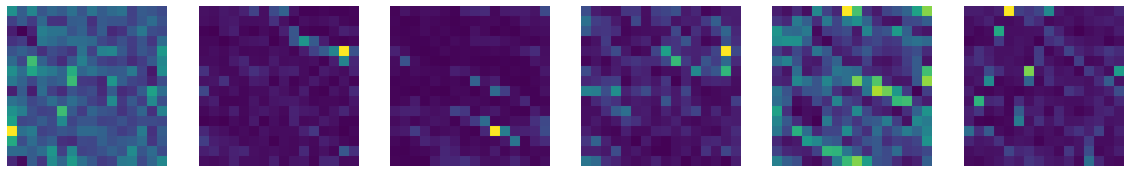

In [120]:
plt.figure(figsize=(20,20))
for i in range(nh):
    plt.subplot(1,6,i+1)
    plt.imshow(attentions[i,:,:])
    plt.axis('off')